## scVI data integration for healthy PBMC pilot study (Cai 2020 and Cai 2022)

**Objective**: Run scVI data integration model for healthy PBMCs [Cai 2020 and Cai 2022]


- **Developed by**: Mairi McClean

- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**

- v230321

- Following this tutorial:https://docs.scvi-tools.org/en/stable/tutorials/notebooks/harmonization.html



In [1]:
!pip install --quiet scvi-colab
!pip install --quiet scib-metrics
from scvi_colab import install

install()

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import scanpy as sc
import scvi
from rich import print
from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde
from scvi_colab import install

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Read in datasets for integration
> Cai 2020 + Cai 2022

### Read in datasets

- Read in _Cai Y et al 2020_

In [4]:
caiy2020 = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/processed_files/abridged_qc/human/Cai2020_scRNA_PBMC_mm230315_qcd.h5ad')
caiy2020

AnnData object with n_obs × n_vars = 73146 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'
    layers: 'counts', 'sqrt_norm'

In [45]:
caiy2020.obs['status'].value_counts()

active_TB    33104
Healthy      22049
latent_TB    17993
Name: status, dtype: int64

- Read in _Cai Y et al 2022_

In [50]:
caiy2022 = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/processed_files/abridged_qc/human/Cai2022_scRNA_PBMC_mm230315_qcd.h5ad')
caiy2022.obs['status'] = 'active_TB'
caiy2022

AnnData object with n_obs × n_vars = 25417 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'status'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [52]:
# So Cai2022 has no healthy controls? Publication suggests that all samples were taken from either TPE, pneumonia, or lung cancer

caiy2022.obs['status'].value_counts()

active_TB    25417
Name: status, dtype: int64

### Merge datasets

In [6]:
caiy_tb = caiy2020.concatenate(caiy2022, batch_key = 'dataset', batch_categories = ['caiy2020', 'caiy2022'], join = 'inner')
caiy_tb

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 98563 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'object', 'protocol', 'dataset'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'n_cells_by_counts-caiy2022', 'mean_counts-caiy2022', 'pct_dropout_by_counts-caiy2022', 'total_counts-caiy2022'
    layers: 'counts', 'sqrt_norm'

### Check that anndata object only contains PBMC scRNA from healthy donors

In [7]:
caiy_tb.obs

,study,individual,sample,tissue,donor,age,gender,status,data_type,centre,...,percent_mt2,n_counts,percent_chrY,XIST-counts,S_score,G2M_score,predicted_doublets,object,protocol,dataset
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAACAATC-acTB3-caiy2020,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,0.060170,5634.0,0.053248,0.0,-0.352188,-0.193287,0.0,NaN,NaN,caiy2020
AAACCTGAGAAGGTGA-acTB3-caiy2020,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,0.016686,3536.0,0.113122,0.0,-0.064944,-0.071169,0.0,NaN,NaN,caiy2020
AAACCTGAGATCTGCT-acTB3-caiy2020,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,0.099675,1846.0,0.054171,0.0,-0.231399,-0.080643,0.0,NaN,NaN,caiy2020
AAACCTGAGCACAGGT-acTB3-caiy2020,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,0.045580,3993.0,0.075131,0.0,-0.227884,-0.258770,0.0,NaN,NaN,caiy2020
AAACCTGAGCGTGAAC-acTB3-caiy2020,CaiY_2021,SAMN14048025,PBMC_TB_3,PBMC,SAMN14048025,34,male,active_TB,scRNAseq,Shenzhen University,...,0.024570,2035.0,0.147420,0.0,0.020959,0.025030,0.0,NaN,NaN,caiy2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCCATCCT-HRS100513-pbmc_scRNAseq-caiy2022,CaiY_2022,HRI068293,HRS100513,PBMC,P4,NaN,NaN,active_TB,scRNAseq,Shenzhen University,...,0.052279,746.0,0.000000,0.0,-0.137711,-0.152166,0.0,HRS100513,pbmc_scRNAseq,caiy2022
TTTGTCAGTGCTGTAT-HRS100513-pbmc_scRNAseq-caiy2022,CaiY_2022,HRI068293,HRS100513,PBMC,P4,NaN,NaN,active_TB,scRNAseq,Shenzhen University,...,0.051491,369.0,0.000000,0.0,0.130521,0.092987,0.0,HRS100513,pbmc_scRNAseq,caiy2022
TTTGTCAGTGTGGCTC-HRS100513-pbmc_scRNAseq-caiy2022,CaiY_2022,HRI068293,HRS100513,PBMC,P4,NaN,NaN,active_TB,scRNAseq,Shenzhen University,...,0.028736,348.0,0.000000,0.0,-0.043432,-0.034049,0.0,HRS100513,pbmc_scRNAseq,caiy2022


In [8]:
caiy_tb.obs['data_type'].value_counts()

scRNAseq    98563
Name: data_type, dtype: int64

In [9]:
caiy_tb.obs['tissue'].value_counts()

PBMC    98563
Name: tissue, dtype: int64

In [10]:
caiy_tb.obs['status'].value_counts()

active_TB    58521
Healthy      22049
latent_TB    17993
Name: status, dtype: int64

In [11]:
caiy_healthy = caiy_tb[~caiy_tb.obs['status'].isin(['active_TB', 'latent_TB']),:]

In [12]:
caiy_healthy.obs['status'].value_counts()

Healthy    22049
Name: status, dtype: int64

### Check merged anndata object for downstream analysis


In [35]:
caiy_healthy

View of AnnData object with n_obs × n_vars = 22049 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'object', 'protocol', 'dataset'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'n_cells_by_counts-caiy2022', 'mean_counts-caiy2022', 'pct_dropout_by_counts-caiy2022', 'total_counts-caiy2022'
    layers: 'counts', 'sqrt_norm'

In [38]:
caiy_tb.obs['study'].value_counts()

CaiY_2021    73146
CaiY_2022    25417
Name: study, dtype: int64

In [39]:
caiy_healthy.obs['study'].value_counts

<bound method IndexOpsMixin.value_counts of barcode
AAACCTGAGATGGCGT-H2-caiy2020    CaiY_2021
AAACCTGAGATGTGTA-H2-caiy2020    CaiY_2021
AAACCTGAGCAACGGT-H2-caiy2020    CaiY_2021
AAACCTGAGCCATCGC-H2-caiy2020    CaiY_2021
AAACCTGAGGTGATTA-H2-caiy2020    CaiY_2021
                                  ...    
TTTGTCAGTCGCGGTT-H1-caiy2020    CaiY_2021
TTTGTCAGTCGCTTCT-H1-caiy2020    CaiY_2021
TTTGTCAGTTCGAATC-H1-caiy2020    CaiY_2021
TTTGTCAGTTTGGGCC-H1-caiy2020    CaiY_2021
TTTGTCATCCCATTAT-H1-caiy2020    CaiY_2021
Name: study, Length: 22049, dtype: object>

In [42]:
caiy_tb.obs['sample'].value_counts()

PBMC_TB_1      11521
PBMC_HC_1      11275
PBMC_TB_3      11174
PBMC_HC_2      10774
PBMC_TB_2      10409
PBMC_LTBI_2     9846
HRS100507       8573
PBMC_LTBI_1     8147
HRS100513       6828
HRS100511       5250
HRS180101       2578
HRS180103       2188
Name: sample, dtype: int64

In [43]:
caiy_healthy.obs['sample'].value_counts()

PBMC_HC_1    11275
PBMC_HC_2    10774
Name: sample, dtype: int64

In [ ]:
# There appears to be no healthy controls in the Cai 2022 data; check this

### Calculate HVGs

In [13]:
adata = caiy_healthy.copy()
adata.layers['counts'] = adata.X.copy()

In [14]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


### Integration with scVI


In [15]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [16]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [33]:
scvi.model.SCVI.view_anndata_setup(vae)

Anndata setup with scvi-tools version 0.20.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 22049 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 8000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │     H2     │          0          │
│                    │     H1     │          1          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [17]:
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 363/363: 100%|██████████| 363/363 [1:01:22<00:00, 10.11s/it, loss=2.2e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=363` reached.


Epoch 363/363: 100%|██████████| 363/363 [1:01:22<00:00, 10.14s/it, loss=2.2e+03, v_num=1]


In [18]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [19]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)

In [21]:
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b)
  Referenced from: '/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/torch/lib/libc10.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


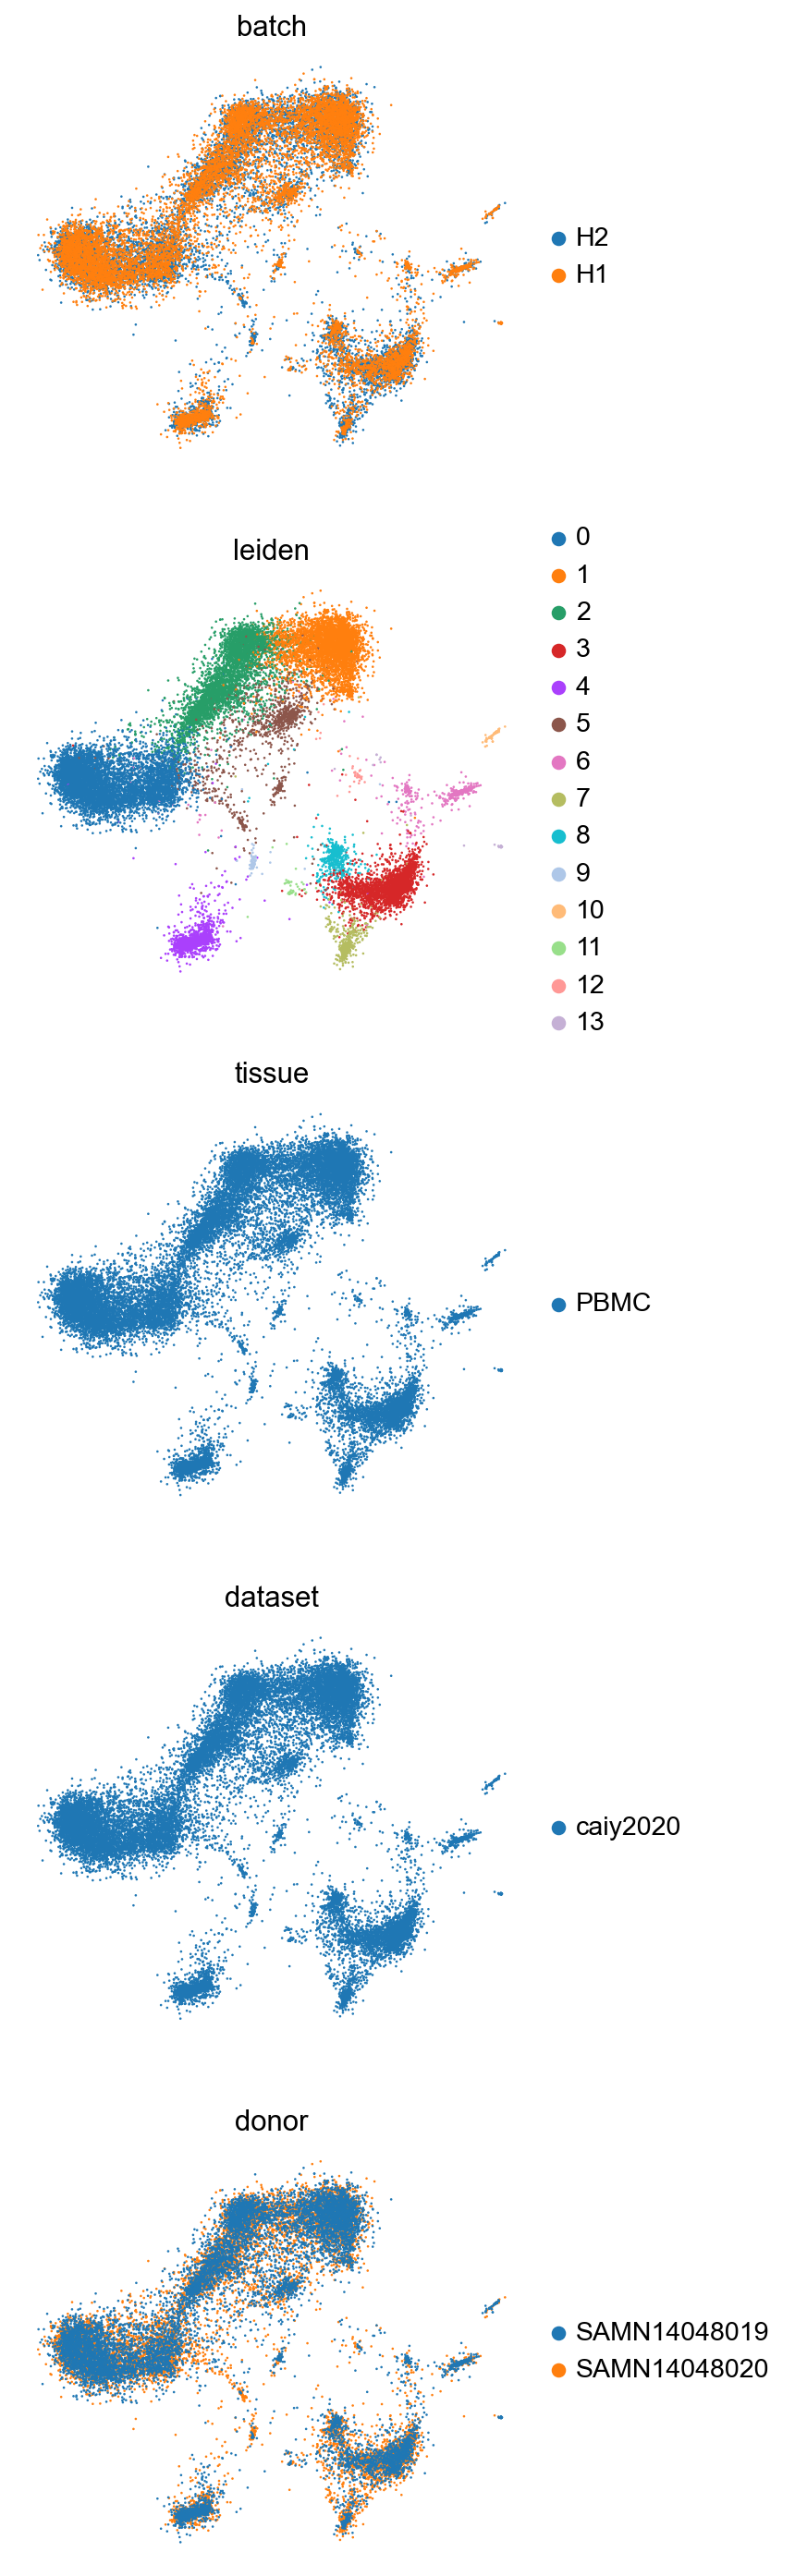

In [25]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["batch", "leiden", "tissue", "dataset", "donor"],
    frameon=False,
    ncols=1,
)